In [1]:
%pylab inline
import geopandas as gpd
import pandas as pd
import os
import mplleaflet
import OpticalRS
import numpy as np
import scipy as sp
from datetime import datetime as dt

in_data_dir = "/Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM"
infp = lambda s: os.path.join(in_data_dir, s)
out_data_dir = "/Users/datateam/repos/spatial_analysis/HabMetricsOut"
outfp = lambda s: os.path.join(out_data_dir, s)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
alaska_yukon = infp('yukon_90dem.tif')

### Yukon Elevation Problem

There are some erroneously large elevation values in the Yukon DEM. We'll find them and mask them.

In [3]:
yukrds = OpticalRS.RasterDS(alaska_yukon)

In [4]:
%%time 
yukarr = yukrds.band_array

CPU times: user 2.49 s, sys: 1.47 s, total: 3.96 s
Wall time: 4.06 s


In [5]:
(yukarr.flatten() == yukarr.max()).sum()

18166

In [6]:
yukarr.flatten().shape

(237880402,)

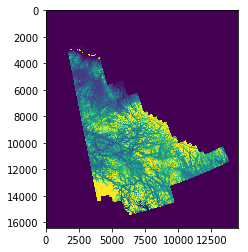

In [7]:
imshow(yukarr.squeeze(), vmax=1700)

Zooming in we see our issue:

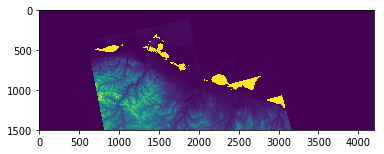

In [8]:
imshow(yukarr.squeeze()[2500:4000,1000:5200], vmax=1700)

In [9]:
out_yuk = infp('yukon_90dem_fixed.tif')

Anything above 40000 is given the NoDataValue of 65536 to mask the erroneous data.

In [10]:
!gdal_calc.py -A $alaska_yukon --calc="((A>=40000)*65536)+((A<40000)*A)" --outfile=$out_yuk --NoDataValue=65536

0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done


# Elevation

I need to attribute regions and watersheds with the following information:
* Mean elevation
* Minimum elevation
* Maximum elevation
* Median elevation
* Standard deviation of elevation
* Range of elevation
* Coefficient of variation of elevation

## Mosaic several DEMs

Now, I need to mosaic three DEMs in order to create a complete DEM for our regions of interest.
* `ak_dem_albers.tif` is a DEM for a region that covers roughly the state of Alaska.
* `bc_dem1.tif` is a DEM for a transboundary region between British Columbia and Alaska.
* `yukon_90dem_fixed.tif` is a DEM for a transboundary region between the Yukon and Alaska.

In [11]:
alaska_main = infp('ak_dem_albers.tif')
alaska_bc = infp('bc_dem1.tif') #no data value is -32768

I'll first make sure these DEMs are in the same projection. I'll start by defining output paths.

In [12]:
# deleted those that were already created before running this:
alaska_main_3338 = infp('DEM_mosaic_3338/ak_usa_3338.tif')
alaska_bc_3338 = infp('DEM_mosaic_3338/alaska_bc_3338.tif')
alaska_yukon_3338 = infp('DEM_mosaic_3338/alaska_yukon_3338.tif')


And use gdal to reproject each DEM.

In [13]:
!gdalwarp -t_srs EPSG:3338 $alaska_main $alaska_main_3338

Creating output file that is 49563P x 39383L.
Processing /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/ak_dem_albers.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


I'll also mask "no data" values (value=0) in the AK state DEM so that I can successfully mosaic.

In [14]:
alaska_main_masked_3338 = infp('DEM_mosaic_3338/ak_usa_masked_3338.tif')

In [15]:
!gdalwarp -srcnodata "value [0]" $alaska_main_3338 $alaska_main_masked_3338

Creating output file that is 49563P x 39383L.
Processing /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/DEM_mosaic_3338/ak_usa_3338.tif [1/1] : 0Copying nodata values from source /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/DEM_mosaic_3338/ak_usa_3338.tif to destination /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/DEM_mosaic_3338/ak_usa_masked_3338.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


I'll now repeat this process for Yukon and BC tiffs.

In [16]:
!gdalwarp -t_srs EPSG:3338 $alaska_bc $alaska_bc_3338

Creating output file that is 30387P x 27147L.
Processing /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/bc_dem1.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/bc_dem1.tif.
Copying nodata values from source /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/bc_dem1.tif to destination /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/DEM_mosaic_3338/alaska_bc_3338.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
!gdalwarp -t_srs EPSG:3338 $out_yuk $alaska_yukon_3338

Creating output file that is 14489P x 16418L.
Processing /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/yukon_90dem_fixed.tif [1/1] : 0Using internal nodata values (e.g. 65536) for image /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/yukon_90dem_fixed.tif.
Copying nodata values from source /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/yukon_90dem_fixed.tif to destination /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/DEM_mosaic_3338/alaska_yukon_3338.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Previously alaska_yukon_3338 was masked but doing so seems to reinstate the 65k values

In [31]:
# alaska_yukon_masked_3338 = infp('DEM_mosaic_3338/ak_yukon_masked_3338.tif')

In [32]:
# !gdalwarp -srcnodata "value [0]" $alaska_yukon_3338 $alaska_yukon_masked_3338 
# THINGS GO WRONG HERE

Processing /Users/datateam/repos/spatial_analysis/HabitatMetrics/DEM/DEM_mosaic_3338/alaska_yukon_3338.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


I'll check the pixel sizes of the reprojected rasters to see how they need to be resampled.

In [18]:
!gdalinfo $alaska_main_masked_3338 | grep Pixel
!gdalinfo $alaska_bc_3338 | grep Pixel
!gdalinfo $alaska_yukon_3338 | grep Pixel

Pixel Size = (61.111599999999996,-61.111599999999996)
Pixel Size = (95.005093625297874,-95.005093625297874)
Pixel Size = (89.999999999999901,-89.999999999999901)


Rasters should be resampled to the lowest resolution, roughly 95 meters for the BC tiff. I'll mosaic the DEMs using `gdal_merge`.

In [20]:
DEM_alaska = infp('DEM_mosaic_3338/ak_all_regions_3338.tif')

In [21]:
!gdal_merge.py -ps 95.005093625297974 95.005093625297974 -o $DEM_alaska $alaska_yukon_3338 $alaska_main_masked_3338 $alaska_bc_3338
# I changed alaska_yukon_masked_3338 to alaska_yukon_3338 
# isn't 61 the lowest resolution?
# this seems to work min/max: 0, 6182m

0...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
!gdalinfo $DEM_alaska | grep Pixel

Pixel Size = (95.005093625297974,-95.005093625297974)


## Regions

Using our mosaiced DEM, I want to attribute elevation statistics to regions of Alaska. First, I'll load the `regions` file and ensure it's in the Alaska Albers projection. I'll also convert our DEM into a numpy array using OpticalRS.

In [23]:
reg_fp = '/Users/datateam/repos/spatial_analysis/HUC8_rebuild/output/sasap_regions.shp'
regions = gpd.read_file(reg_fp).to_crs(epsg=3338)

In [24]:
%%time
rds = OpticalRS.RasterDS(DEM_alaska)
bandarr1 = rds.band_array

CPU times: user 16.2 s, sys: 16.3 s, total: 32.5 s
Wall time: 34.4 s


I'll write a function to calculate the summary statistics above from the elevation numpy array by each individual geometry. I'll first evaluate a sample geometry (the Yukon).

In [25]:
row = regions.iloc[5]

In [26]:
def stats_elev(rds, row):
    subarr = rds.geometry_subset(row.geometry)
    subarr_c = subarr.compressed()
    mean_arr = subarr_c.mean()
    max_arr = np.amax(subarr_c)
    min_arr = np.amin(subarr_c)
    median_arr = np.median(subarr_c)
    std_arr = np.std(subarr_c)
    coef_var_arr = std_arr/mean_arr
    range_arr = np.ptp(subarr_c)
    return [mean_arr, max_arr, min_arr, median_arr, std_arr, coef_var_arr, range_arr]

In [27]:
series = stats_elev(rds, row)
series
#the output didn't change

[176.43025641486, 2290, 0, 37.0, 265.7240584064764, 1.5061138820863582, 2290]

That works well, so I'll apply all geometries in my `regions` GeoDataFrame through the same function.

In [28]:
def stats_elev_df(rds, gdf):
    new_series = gdf.apply(lambda r: stats_elev(rds, r), axis=1)
    return new_series

In [29]:
series2 = stats_elev_df(rds, regions)
series2
#output is slightly different than before

0     [107.10794195446664, 2835, 0, 0.0, 221.9202886...
1     [363.9594369440124, 2741, 0, 195.0, 424.639436...
2     [227.4162934356083, 2813, 0, 112.0, 293.235196...
3     [149.16377424427256, 2506, 0, 9.0, 254.8231216...
4     [1121.338464447697, 5959, 0, 988.0, 734.162207...
5     [176.43025641486, 2290, 0, 37.0, 265.724058406...
6     [277.9730755233999, 4481, 0, 185.0, 288.964992...
7     [272.6493970286879, 3371, 0, 176.0, 348.665146...
8     [733.1351531876119, 6182, 0, 688.0, 608.508006...
9     [168.71265260960723, 1401, 0, 115.0, 178.29442...
10    [405.95234614767463, 3994, 0, 74.0, 594.104630...
11    [840.7058016703972, 5951, 0, 827.0, 665.956740...
12    [678.868778959133, 6177, 0, 620.0, 507.0394412...
dtype: object

To turn this series of lists into a DataFrame, I'll use the `vstack` method, which takes a sequence of arrays and stacks them vertically to make a single array. I can then put this single array inside the DataFrame constructor. The final step is to attribute this data to the original regional shapefile (GeoDataFrame) using an attribute join in geopandas.

In [30]:
elev_regions = pd.DataFrame(np.vstack(series2), columns=["mean_elevation", "max_elevation", "min_elevation", "median_elevation","std_elevation", "coeff_var_elevation","range_elevation"])
elev_regions['region'] = regions.region
regions = regions.merge(elev_regions, on="region")
regions.head()
#max elevation changed from 65k to 2741

,region_id,region,geometry,mean_elevation,max_elevation,min_elevation,median_elevation,std_elevation,coeff_var_elevation,range_elevation
0,1,Aleutian Islands,(POLYGON ((-1156665.959195634 420855.093106978...,107.107942,2835.0,0.0,0.0,221.920289,2.071931,2835.0
1,2,Arctic,"POLYGON ((571289.9424044377 2143072.479559345,...",363.959437,2741.0,0.0,195.0,424.639436,1.166722,2741.0
2,3,Bristol Bay,(POLYGON ((-339688.5870041371 973904.876117813...,227.416293,2813.0,0.0,112.0,293.235196,1.289420,2813.0
3,4,Chignik,(POLYGON ((-114381.9018728056 649966.806579367...,149.163774,2506.0,0.0,9.0,254.823122,1.708345,2506.0
4,5,Copper River,"POLYGON ((561012.0068005103 1148300.750064242,...",1121.338464,5959.0,0.0,988.0,734.162207,0.654720,5959.0


In [31]:
out_data_dir = "/Users/datateam/repos/spatial_analysis/HabMetricsOut"
outfp = lambda s: os.path.join(out_data_dir, s)

In [32]:
regions.to_file(outfp('Regions_Elevation.shp'))
regions.drop('geometry', axis='columns').to_csv(outfp('Regions_Elevation.csv'))

## Watersheds

I'll repeat the subsetting process above for HUC8s. I want to assess the following for each watershed:
* Mean elevation
* Minimum elevation
* Maximum elevation
* Median elevation
* Standard deviation of elevation
* Range of elevation
* Coefficient of variation of elevation

In [33]:
watersheds_fp = "/Users/datateam/repos/spatial_analysis/HUC8_rebuild/output/sasap_watersheds_gapfix.shp"
watersheds = gpd.read_file(watersheds_fp).to_crs(epsg=3338) 

In [34]:
row = watersheds.iloc[5]

In [35]:
series = stats_elev(rds, row)
series

[1503.3625503983124,
 2362,
 713,
 1532.0,
 330.9080586000363,
 0.22011194738911316,
 1649]

In [36]:
series2 = stats_elev_df(rds, watersheds)

In [37]:
elev_watersheds = pd.DataFrame(np.vstack(series2), columns=["mean_elevation", "max_elevation", "min_elevation", "median_elevation","std_elevation", "coeff_var_elevation","range_elevation"])
elev_watersheds['id_numeric'] = watersheds.id_numeric
watersheds = watersheds.merge(elev_watersheds, on="id_numeric")
watersheds.sort_values('max_elevation', ascending=False).head()

,id_numeric,name,id_origina,source,geometry,mean_elevation,max_elevation,min_elevation,median_elevation,std_elevation,coeff_var_elevation,range_elevation
65,19020504,Yentna River,19020504,IJC,"POLYGON ((170387.1288993186 1391194.911164926,...",823.801219,6182.0,6.0,688.0,664.278608,0.806358,6176.0
163,19080310,Kantishna River,19080310,IJC,"POLYGON ((209471.8702805947 1497901.047508164,...",577.118118,6177.0,77.0,336.0,592.124043,1.026001,6100.0
53,19020103,Chitina River,19020103,IJC,"POLYGON ((545518.9120186161 1357307.467988568,...",1642.122944,5959.0,143.0,1612.0,798.193488,0.486074,5816.0
49,19010405,Yakutat Bay-Gulf of Alaska,19010405,IJC,"POLYGON ((875092.2544799988 1115507.894661564,...",950.054960,5951.0,0.0,620.0,943.772288,0.993387,5951.0
63,19020502,Chulitna River,19020502,IJC,(POLYGON ((198002.9888731728 1377926.754576676...,1080.776142,5724.0,90.0,1004.0,650.058519,0.601474,5634.0


In [38]:
watersheds.to_file(outfp('Watersheds_Elevation.shp'))
watersheds.drop('geometry', axis='columns').to_csv(outfp('Watersheds_Elevation.csv'))